In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')
import scipy
import noisereduce as nr
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================================================
# 1. CHARGEMENT DES DONNÉES
# =========================================================

# Function to load paths and labels from a directory
def load_paths_and_labels(directory):
    paths = []
    labels = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.wav'):
                paths.append(os.path.join(dirname, filename))
                label = filename.split('_')[-1].split('.')[0]
                labels.append(label)
    return paths, labels

# Load paths and labels for each set
train_paths, train_labels = load_paths_and_labels('C:/Users/Abdelhamied/Desktop/ENSEA/Stage2A/Datasets/Wave2Vec/model1/train')
val_paths, val_labels = load_paths_and_labels('C:/Users/Abdelhamied/Desktop/ENSEA/Stage2A/Datasets/Wave2Vec/model1/val')
test_paths, test_labels = load_paths_and_labels('C:/Users/Abdelhamied/Desktop/ENSEA/Stage2A/Datasets/Wave2Vec/model1/test')

print("Dataset is successfully loaded")



Dataset is successfully loaded


In [2]:

# Encode labels
encoder = LabelEncoder()
all_labels = train_labels + val_labels + test_labels
encoder.fit(all_labels)

train_labels = encoder.transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

print("Labels encoded")

# Ensure all audio files are 16kHz
def ensure_sample_rate(audio_path, sr=16000):
    audio, _ = librosa.load(audio_path, sr=sr)
    return audio

# Prepare dataset for Wav2Vec2
class SpeechEmotionDataset(Dataset):
    def __init__(self, paths, labels, max_length=16000*3):  # Max length for 3 seconds of audio at 16kHz
        self.paths = paths
        self.labels = labels
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
        self.max_length = max_length

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        audio_path = self.paths[idx]
        label = self.labels[idx]
        audio = ensure_sample_rate(audio_path)  # Ensure 16kHz sample rate
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            audio = np.pad(audio, (0, self.max_length - len(audio)))
        inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

print("Dataset class created")



# Create DataLoaders
train_dataset = SpeechEmotionDataset(train_paths, train_labels)
val_dataset = SpeechEmotionDataset(val_paths, val_labels)
test_dataset = SpeechEmotionDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("DataLoaders created")

# =========================================================
# 2. ENTRAÎNEMENT DU MODÈLE
# =========================================================


# Model Initialization
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=len(encoder.classes_))
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model and processor initialized and moved to device")


# Training
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 15
best_val_loss = float('inf')
patience = 2
trigger_times = 0

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    total_train_loss = 0
    correct_train_preds = 0
    model.train()
    for batch in train_loader:
        inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    total_val_loss = 0
    correct_val_preds = 0
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs).logits
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            correct_val_preds += (preds == labels.cpu().numpy()).sum()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        # Save the best model and processor
        model.save_pretrained("best_speech_emotion_model")
        processor.save_pretrained("best_speech_emotion_model")
        print("Best model and processor saved")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break



Labels encoded
Dataset class created
DataLoaders created


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and processor initialized and moved to device
Epoch 1/15, Train Loss: 1.8217584235327584, Train Accuracy: 0.4630738522954092, Val Loss: 1.5447759543146407, Val Accuracy: 0.7666666666666667
Best model and processor saved
Epoch 2/15, Train Loss: 1.282732864220937, Train Accuracy: 0.8622754491017964, Val Loss: 0.9242356547287532, Val Accuracy: 0.9809523809523809
Best model and processor saved
Epoch 3/15, Train Loss: 0.770761627999563, Train Accuracy: 0.9960079840319361, Val Loss: 0.5299209015710014, Val Accuracy: 1.0
Best model and processor saved
Epoch 4/15, Train Loss: 0.49696165086731076, Train Accuracy: 0.999001996007984, Val Loss: 0.3684133951153074, Val Accuracy: 0.9904761904761905
Best model and processor saved
Epoch 5/15, Train Loss: 0.3556675163526384, Train Accuracy: 1.0, Val Loss: 0.2628576010465622, Val Accuracy: 1.0
Best model and processor saved
Epoch 6/15, Train Loss: 0.2695676067045757, Train Accuracy: 1.0, Val Loss: 0.2018264372433935, Val Accuracy: 1.0
Best model a

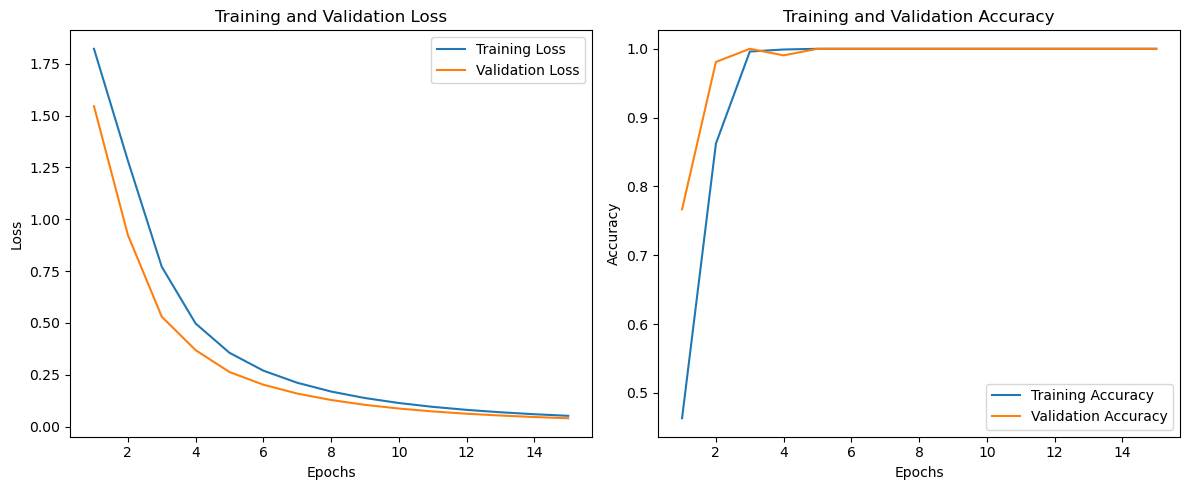

In [3]:

# Plotting training and validation loss and accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


In [4]:

# =========================================================
# 3. ÉVALUATION DU MODÈLE
# =========================================================

# Load the best model for final evaluation
model = Wav2Vec2ForSequenceClassification.from_pretrained("best_speech_emotion_model")
model.to(device)
model.eval()
print("Best model loaded for evaluation")

# Evaluate on validation set
all_val_preds = []
all_val_labels = []
with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_val_preds.extend(preds)
        all_val_labels.extend(labels.cpu().numpy())

print("Validation Accuracy:", accuracy_score(all_val_labels, all_val_preds))
print("Validation Classification Report:\n", classification_report(all_val_labels, all_val_preds, target_names=encoder.classes_))



Best model loaded for evaluation
Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

       angry       1.00      1.00      1.00        30
     disgust       1.00      1.00      1.00        30
        fear       1.00      1.00      1.00        30
       happy       1.00      1.00      1.00        30
     neutral       1.00      1.00      1.00        30
          ps       1.00      1.00      1.00        30
         sad       1.00      1.00      1.00        30

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



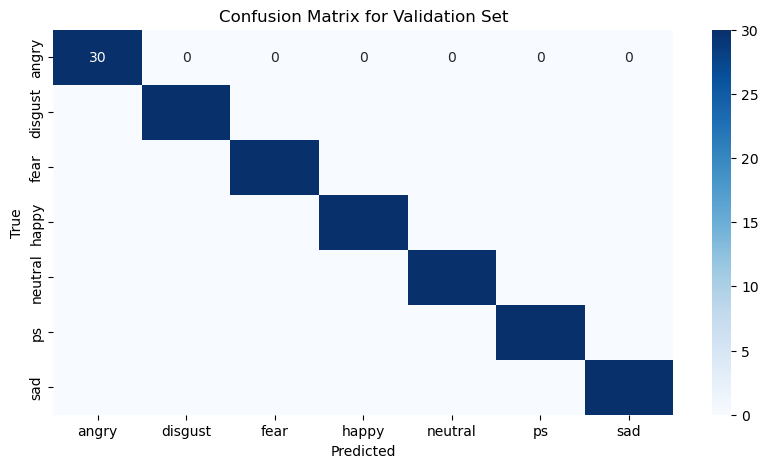

In [5]:
# Confusion matrix for validation set
val_cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(10,5))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Evaluate on test set
all_test_preds = []
all_test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs).logits
        preds = torch.argmax

In [6]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# Assuming your problem is multi-class classification
# Evaluate on validation set
all_val_labels = []
all_val_probs = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs).logits
        
        probs = F.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
        
        all_val_labels.extend(labels.cpu().numpy())
        all_val_probs.extend(probs)

# Compute ROC-AUC score
auc_score = roc_auc_score(all_val_labels, np.array(all_val_probs), multi_class='ovr')
print("Validation ROC-AUC Score:", auc_score)



Validation ROC-AUC Score: 1.0


In [7]:
from sklearn.metrics import log_loss
import torch.nn.functional as F

# Assuming you have the predicted probabilities
model.eval()
all_val_labels = []
all_val_probs = []

with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.squeeze(1).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs).logits
        
        probs = F.softmax(outputs, dim=-1).detach().cpu().numpy()
        
        all_val_labels.extend(labels.cpu().numpy())
        all_val_probs.extend(probs)

logloss = log_loss(all_val_labels, all_val_probs)
print("Validation Log Loss:", logloss)


Validation Log Loss: 0.040280561077188116


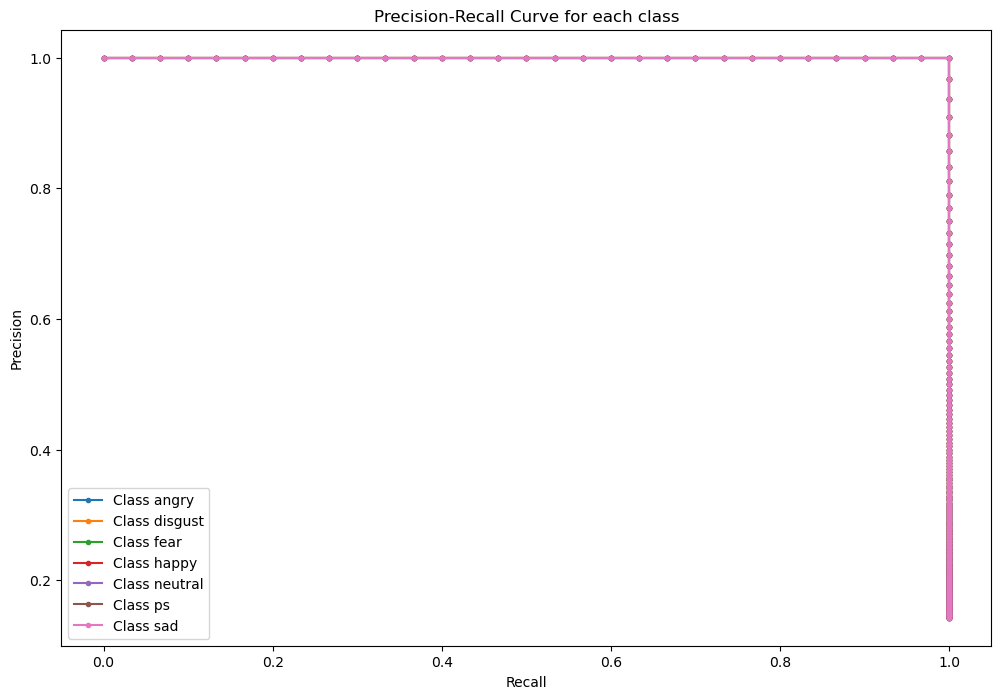

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
all_val_labels_binarized = label_binarize(all_val_labels, classes=range(len(encoder.classes_)))

# Calculate precision-recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(encoder.classes_)):
    precision, recall, _ = precision_recall_curve(all_val_labels_binarized[:, i], np.array(all_val_probs)[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {encoder.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.show()


In [9]:
"""
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Load the trained model and processor
model_path = "best_speech_emotion_model"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to ensure the sample rate is 16kHz
def ensure_sample_rate(audio_path, sr=16000):
    audio, _ = librosa.load(audio_path, sr=sr)
    return audio

# Function to predict the emotion of a given audio file
def predict_emotion(audio_path):
    audio = ensure_sample_rate(audio_path)
    max_length = 16000 * 3  # Max length for 3 seconds of audio at 16kHz
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)))
    
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs).logits
        predicted_label_id = torch.argmax(outputs, dim=1).item()
    
    predicted_label = encoder.inverse_transform([predicted_label_id])[0]
    return predicted_label
"""
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
from sklearn.preprocessing import LabelEncoder

# Load the trained model and processor
model_path = "best_speech_emotion_model"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Ensure sample rate function
def ensure_sample_rate(audio_path, sr=16000):
    audio, _ = librosa.load(audio_path, sr=sr)
    return audio

# Predict emotion function
def predict_emotion(audio_path):
    audio = ensure_sample_rate(audio_path)
    max_length = 16000 * 3  # Max length for 3 seconds of audio at 16kHz
    if (len(audio) > max_length):
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)))

    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits
        probabilities = torch.nn.functional.softmax(outputs, dim=-1)[0]

    predicted_label_id = torch.argmax(outputs, dim=1).item()
    predicted_label = encoder.inverse_transform([predicted_label_id])[0]
    return predicted_label, probabilities.cpu().numpy()

The predicted emotion for the audio file is: angry
Emotion: angry, Probability: 0.9567
Emotion: disgust, Probability: 0.0038
Emotion: fear, Probability: 0.0095
Emotion: happy, Probability: 0.0083
Emotion: neutral, Probability: 0.0099
Emotion: ps, Probability: 0.0078
Emotion: sad, Probability: 0.0040
The predicted emotion for the audio file is: angry


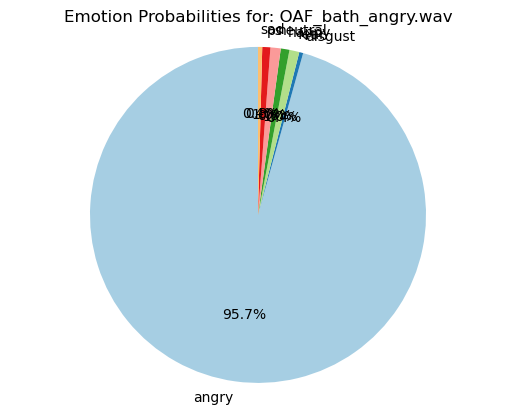

In [10]:

# Example usage
audio_path = "C:/Users/Abdelhamied/Desktop/ENSEA/Stage2A/test/Audio/OAF_bath_angry.wav"
        #C:\Users\Abdelhamied\Desktop\ENSEA\Stage2A\test\Audio
predicted_emotion, probabilities = predict_emotion(audio_path)

# Display the predicted emotion and probabilities for each emotion
print(f"The predicted emotion for the audio file is: {predicted_emotion}")
for emotion, prob in zip(encoder.classes_, probabilities):
    print(f"Emotion: {emotion}, Probability: {prob:.4f}")


# Display the predicted emotion
print(f"The predicted emotion for the audio file is: {predicted_emotion}")

# Plot the probabilities in a pie chart
labels = encoder.classes_
fig, ax = plt.subplots()
ax.pie(probabilities, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(np.arange(len(labels))))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title(f"Emotion Probabilities for: {audio_path.split('/')[-1]}")
plt.show()


In [11]:
import os
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# =========================================================
# FONCTION POUR ASSURER LE TAUX D'ÉCHANTILLONNAGE
# =========================================================

def ensure_sample_rate(audio_path, target_sr=16000):
    audio, sr = librosa.load(audio_path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return audio

# =========================================================
# FONCTION DE PRÉDICTION
# =========================================================

def predict_emotion(audio_path):
    model.eval()
    audio = ensure_sample_rate(audio_path)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: inputs[key].to(device) for key in inputs}
    
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]
    predicted_emotion = encoder.inverse_transform([np.argmax(probabilities)])[0]
    
    return predicted_emotion, probabilities

# =========================================================
# FONCTION D'ÉVALUATION
# =========================================================

def evaluate_emotion_folder(folder_path, true_emotion):
    audio_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    correct_predictions = 0
    total_predictions = len(audio_paths)
    
    for audio_path in audio_paths:
        predicted_emotion, probabilities = predict_emotion(audio_path)
        if predicted_emotion == true_emotion:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

# =========================================================
# UTILISATION
# =========================================================

# Dossier contenant les sous-dossiers des émotions
emotions_dir = "C:/Users/Abdelhamied/Desktop/ENSEA/Stage2A/test/Emotions"

# Charger le modèle et le processeur
model = Wav2Vec2ForSequenceClassification.from_pretrained("best_speech_emotion_model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Définir explicitement les étiquettes
emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprised"]

# Encoder les étiquettes
encoder = LabelEncoder()
encoder.fit(emotions)

# Évaluer chaque dossier d'émotions
for emotion in emotions:
    emotion_folder = os.path.join(emotions_dir, emotion)
    if os.path.isdir(emotion_folder):
        accuracy = evaluate_emotion_folder(emotion_folder, emotion)
        print(f"Accuracy for emotion '{emotion}': {accuracy:.4f}")


Accuracy for emotion 'Angry': 0.0089
Accuracy for emotion 'Disgust': 0.0620
Accuracy for emotion 'Fear': 0.0321
Accuracy for emotion 'Happy': 0.9282
Accuracy for emotion 'Neutral': 0.0063
Accuracy for emotion 'Sad': 0.0598
